# Exploration of dataset

### Install needed dependency

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Helper functions

In [33]:
def make_histogram(df: pd.DataFrame, variable: str, binwidth: int, lower_limit: int = None, upper_limit: int = None) -> None:
    if upper_limit is None:
        upper_limit = df[variable].max()

    if lower_limit is None:
        lower_limit = df[variable].min()

    bins = np.arange(lower_limit, upper_limit + binwidth, binwidth)

    plt.hist(df[variable], bins=bins, edgecolor='black',
             alpha=0.75, range=[df[variable].min(), upper_limit])

    plt.ylabel("Count")
    plt.xlabel(variable.title)


def make_scatter_plot(df: pd.DataFrame, paramOne: str, paramTwo: str, logx: bool = False, logy: bool = False):
    plt.plot(df[paramOne], df[paramTwo], '*', alpha=0.1)
    if logx:
        plt.xscale("log")
    if logy:
        plt.yscale('log')
    plt.xlabel(paramOne)
    plt.ylabel(paramTwo)

def min_max_normalize(data: pd.DataFrame) -> pd.DataFrame:
    normalize_df = (data - data.min()) / (data.max() - data.min())
    return normalize_df

## Import dataset


In [34]:
dataframe = pd.read_csv('Titanic.csv')
# Dropping Passenger ID because its the same as rowkey - but indexed from 1.
dataframe.drop('PassengerId', axis=1, inplace=True)

## Explore Data

In [35]:
dataframe.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [36]:
dataframe.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [37]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [38]:
dataframe.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

### Missing Values
There are several common methods for filling in missing data, such as using the mean, median, or mode of the data. These methods work well when the data are normally distributed, but may not be as effective for data with a different distribution.

In the case of the 'Age' column, the data appear to be skewed to the right, with a long tail of older passengers. This suggests that the median may be a better choice for filling in the missing values, as it is less affected by outliers than the mean.

One common method for filling in missing values is to use random values from the dataset. However, this approach may not be suitable for the 'Cabin' column, since there are a large number of unique values and a large amount of missing data. Instead, it may be more effective to fill in the missing cabin values with a single value, such as 'Unknown'. This will preserve the rows with missing data, while still indicating that the values represent a distinct category of data.

For the 'Embarked' column, which has only two missing values, it may be more efficient to simply fill in the missing values with the most common value in that column. This will ensure that the data are complete, without requiring any additional processing.


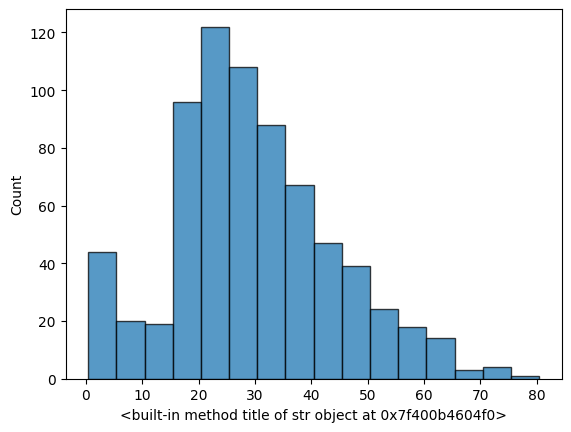

In [39]:
make_histogram(dataframe, variable='Age', binwidth=5)

In [40]:
dataframe['Age'] = dataframe['Age'].fillna(dataframe['Age'].median())
dataframe['Cabin'] = dataframe['Cabin'].fillna('Unknown')
dataframe['Embarked'] = dataframe['Embarked'].fillna(method='ffill')
dataframe.isna().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

#### Additional Columns.

It would be great to have a family column that includes the parents, children, and spouse of each passenger. In addition, we can add another column indicating whether the passenger traveled alone or not

In [41]:
dataframe['Family'] = dataframe['Parch'] + dataframe['SibSp']
dataframe['Traveling_Alone'] = dataframe['Family'] == 0
dataframe['Traveling_Alone'] = dataframe['Traveling_Alone'].astype(int)

#### Splitting 'Survived' & analyze each group.

In [42]:
groups = dataframe.groupby('Survived')
dead = groups.get_group(0)
alive = groups.get_group(1)

In [43]:
def create_hist(dataset, label, group_name):
    dataset[label].hist(alpha=.75, edgecolor='black')
    plt.title(f'Histogram of {label} for {group_name}')
    plt.xlabel(label)
    plt.ylabel('Frequency')
    plt.show()

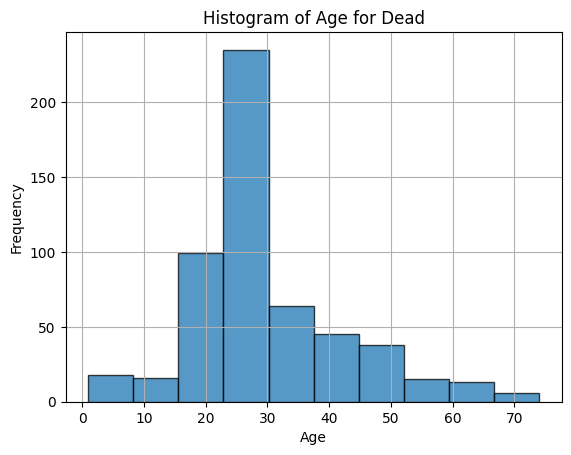

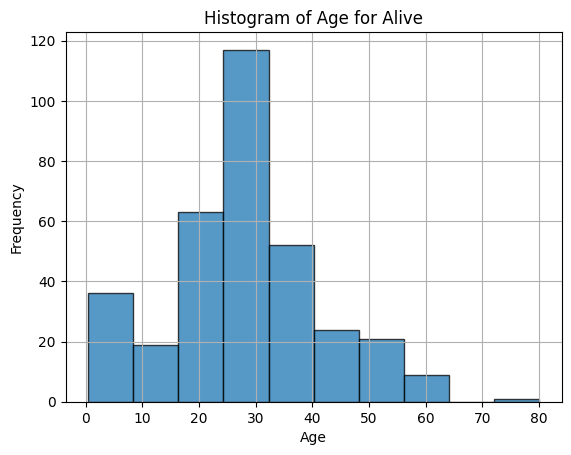

In [44]:
create_hist(dead, 'Age', 'Dead')
create_hist(alive, 'Age', 'Alive')

Based on my observation, there appears to be a higher number of elderly individuals who passed away, while more children survived. Aside from that, the data appears to be evenly distributed.

In [45]:
print('mean_dead:', dead['Age'].mean())
print('var_dead:', dead['Age'].var())
print('skew_dead:', dead['Age'].skew(), end='\n\n')

print('mean_alive:', alive['Age'].mean())
print('var_alive:', alive['Age'].var())
print('skew_alive:', alive['Age'].skew())

mean_dead: 30.028233151183972
var_dead: 156.249657638972
skew_dead: 0.8000636243288174

mean_alive: 28.29143274853801
var_alive: 189.45940585910031
skew_alive: 0.20724531581836741


In [46]:
survived_age = alive['Age']
survived_sex = alive['Sex']
survived_fare = alive['Fare']
survived_pclass = alive['Pclass']

not_survived_age = dead['Age']
not_survived_sex = dead['Sex']
not_survived_fare = dead['Fare']
not_survived_pclass = dead['Pclass']

alive.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family,Traveling_Alone
count,342.0,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,1.0,1.950292,28.291433,0.473684,0.464912,48.395408,0.938596,0.476608
std,0.0,0.863321,13.764425,0.708688,0.771712,66.596998,1.186076,0.500184
min,1.0,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,1.000000,21.000000,0.000000,0.000000,12.475000,0.000000,0.000000
50%,1.0,2.000000,28.000000,0.000000,0.000000,26.000000,1.000000,0.000000
75%,1.0,3.000000,35.000000,1.000000,1.000000,57.000000,2.000000,1.000000
max,1.0,3.000000,80.000000,4.000000,5.000000,512.329200,6.000000,1.000000


In [47]:
dead.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family,Traveling_Alone
count,549.0,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000,549.000000
mean,0.0,2.531876,30.028233,0.553734,0.329690,22.117887,0.883424,0.681239
std,0.0,0.735805,12.499986,1.288399,0.823166,31.388207,1.830669,0.466421
min,0.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,2.000000,23.000000,0.000000,0.000000,7.854200,0.000000,0.000000
50%,0.0,3.000000,28.000000,0.000000,0.000000,10.500000,0.000000,1.000000
75%,0.0,3.000000,35.000000,1.000000,0.000000,26.000000,1.000000,1.000000
max,0.0,3.000000,74.000000,8.000000,6.000000,263.000000,10.000000,1.000000


### Result
There are notable differences between the Fare and Age variables in the two datasets. For example, the minimum value in the Age variable for the survived group is 0.42, while the minimum value for the not survived group is 1. This suggests that every baby under the age of 1 year survived. In terms of Fare, the mean and standard deviation are significantly different between the two groups, indicating that there may be a relationship between Fare and survival. This could suggest that those who paid more for their ticket had a better chance of survival. These differences in Fare and Age could potentially be relevant for understanding and interpreting the results of the analysis.

### TTest

The t-test is a statistical tool used to evaluate whether or not there is a significant difference between the means of two groups. It can be used to compare the means of two independent samples or two related samples, such as matched pairs. The t-test calculates a t-value based on the difference between the means of the two groups and the variability within each group, and compares the t-value to a critical value from a t-distribution to determine the p-value. The p-value is the probability that the difference between the means occurred by chance, and if it is less than the level of significance (usually 0.05), we can conclude that there is a significant difference between the means of the two groups. The t-test is often used in statistical analysis because it is easy to perform and can be used with small sample sizes.

To use the t-test on the 'Sex' column, it will need to be encoded as a numerical value (such as 0 for female and 1 for male) first. This can be done using the LabelEncoder class from sklearn.preprocessing.

In [48]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
survived_sex_encoded = encoder.fit_transform(survived_sex)
not_survived_sex_encoded = encoder.transform(not_survived_sex)

In [49]:
from scipy.stats import ttest_ind

# Test for a difference in the mean between the two groups
def test_diff_dead_or_alive(label, alive_data, dead_data):
    t, p = ttest_ind(alive_data, dead_data)

    if p < 0.05:
        print(f'The mean {label} of the survived group is significantly different from the mean {label} of the not survived group.')
    else:
        print(f'The mean {label} of the survived group is not significantly different from the mean {label} of the not survived group.')

test_diff_dead_or_alive('Age', survived_age, not_survived_age)
test_diff_dead_or_alive('Fare', survived_fare, not_survived_fare)
test_diff_dead_or_alive('PClass', survived_pclass, not_survived_pclass)
test_diff_dead_or_alive('Sex', survived_sex_encoded, not_survived_sex_encoded)

The mean Age of the survived group is not significantly different from the mean Age of the not survived group.
The mean Fare of the survived group is significantly different from the mean Fare of the not survived group.
The mean PClass of the survived group is significantly different from the mean PClass of the not survived group.
The mean Sex of the survived group is significantly different from the mean Sex of the not survived group.


The analysis above reveals a strong connection between passenger class (pclass), fare price, and sex. This finding is consistent with what one might expect, as these variables are known to be related to one another in many situations.

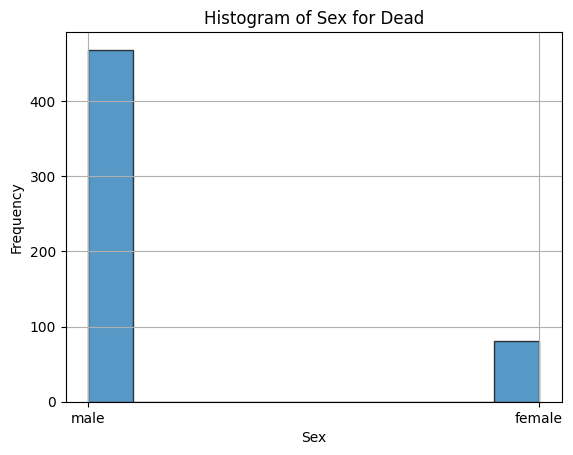

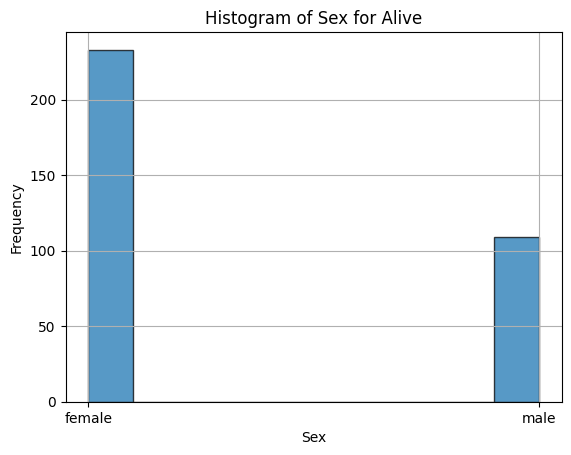

In [50]:
create_hist(dead, 'Sex', 'Dead')
create_hist(alive, 'Sex', 'Alive')

The analysis shows that males had a higher mortality rate and a lower survival rate compared to females. This is likely because, in emergencies, women and children are typically given priority for evacuation. As a result, females and children had a better chance of survival on the Titanic.

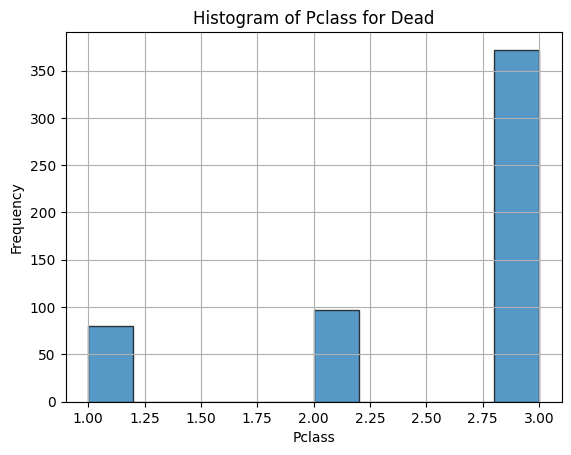

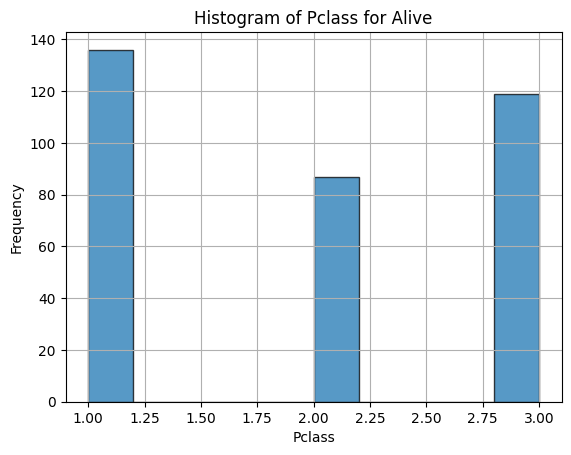

In [51]:
create_hist(dead, 'Pclass', 'Dead')
create_hist(alive, 'Pclass', 'Alive')

In [62]:
pclass_survival_percentages = dataframe.groupby("Pclass")["Survived"].mean() * 100
print(pclass_survival_percentages)

Pclass
1    62.962963
2    47.282609
3    24.236253
Name: Survived, dtype: float64


The analysis of the Titanic dataset reveals that those in the lower class were disproportionately affected by the disaster, with a higher number of fatalities among this group. This may be due to the fact that many of these individuals were workers who were employed in the lower areas of the ship. Additionally, there is a clear trend of higher mortality among the lower class compared to the other classes.

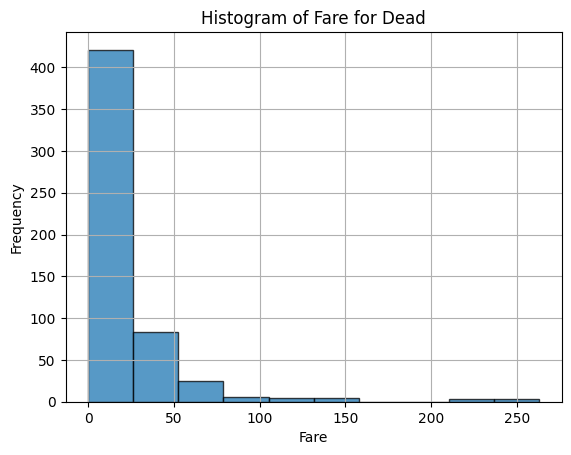

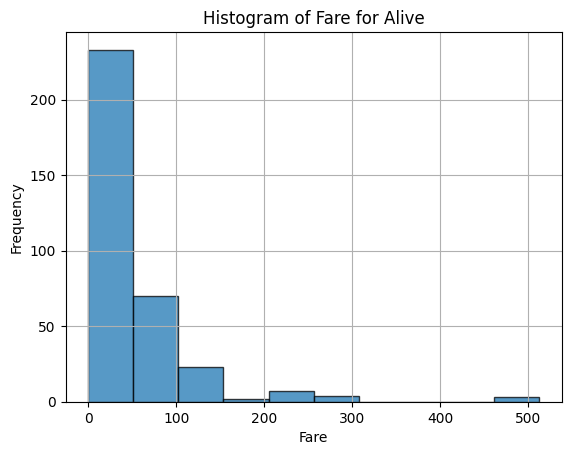

In [52]:
create_hist(dead,'Fare', 'Dead')
create_hist(alive,'Fare', 'Alive')

The death rate among individuals with different fare prices is fairly similar, indicating that there may not be a strong relationship between fare price and survival rate. This suggests that other factors, such as passenger class or location on the ship, may have had a greater impact on an individual's likelihood of survival.

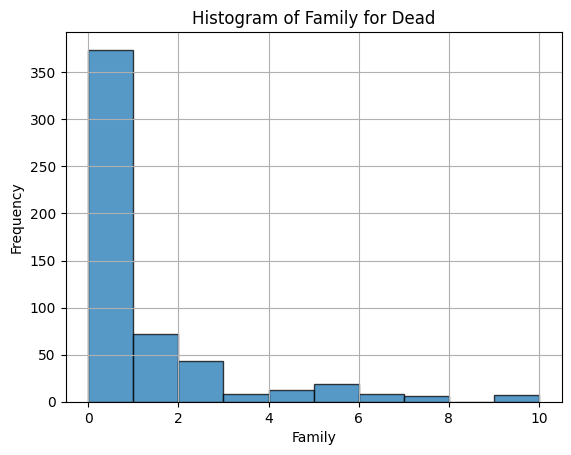

In [53]:
create_hist(dead, 'Family', 'Dead')

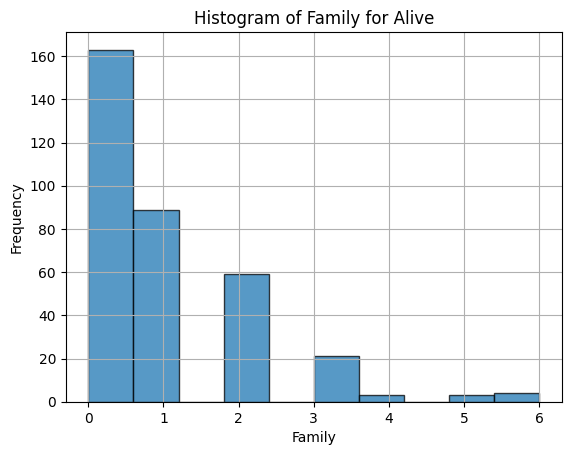

In [54]:
create_hist(alive, 'Family', 'Alive')

The visualization above illustrates that smaller families had a higher survival rate compared to larger families. In fact, there were no individuals with a family size of more than 6 who survived the disaster. This suggests that smaller families may have had an advantage in terms of survival on the Titanic.

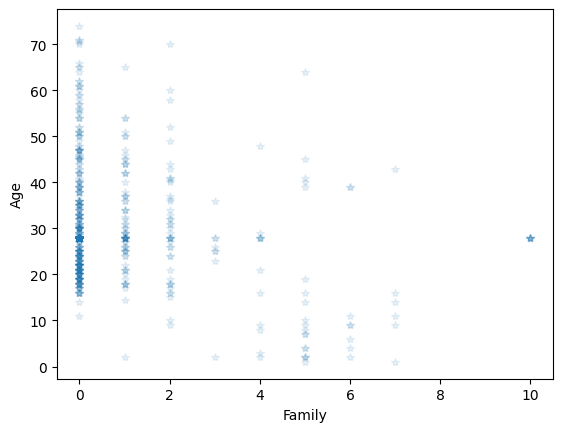

In [55]:
make_scatter_plot(dead, 'Family', 'Age')

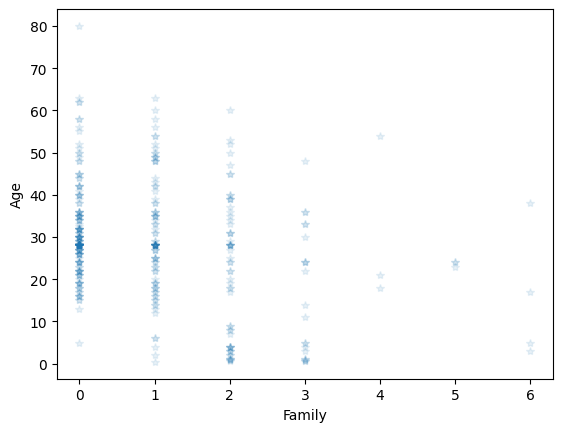

In [56]:
make_scatter_plot(alive, 'Family', 'Age')

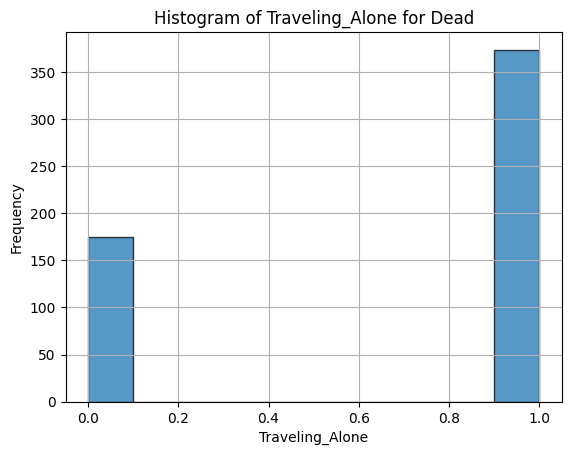

In [57]:
create_hist(dead, 'Traveling_Alone', 'Dead')

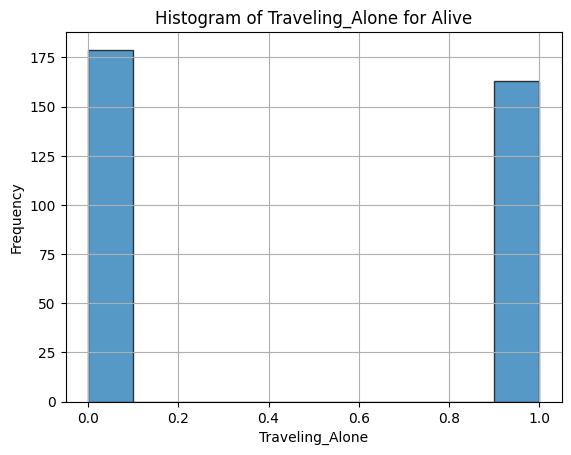

In [58]:
create_hist(alive, 'Traveling_Alone', 'Alive')

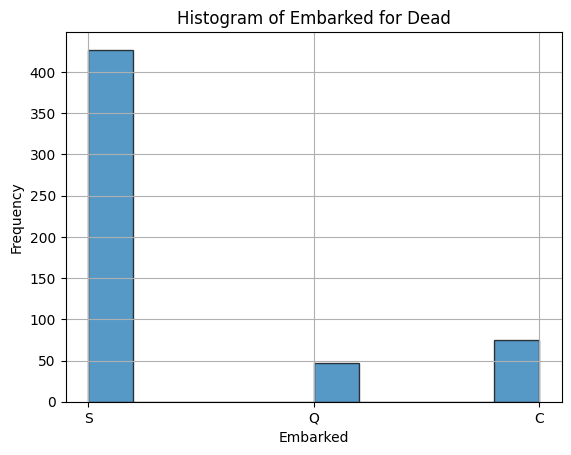

In [64]:
create_hist(dead, 'Embarked', 'Dead')

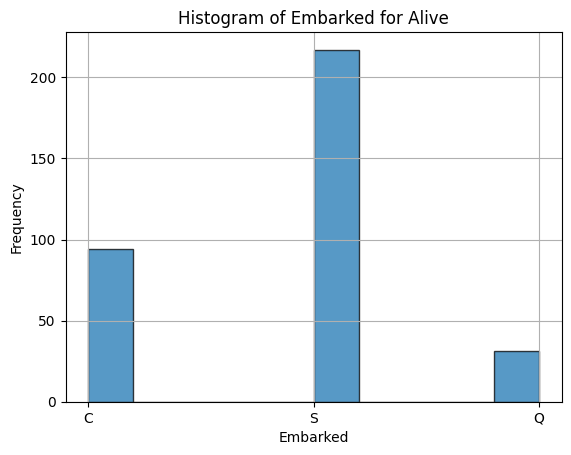

In [65]:
create_hist(alive, 'Embarked', 'Alive')

In [66]:
embarked_survival_percentages = dataframe.groupby("Embarked")["Survived"].mean() * 100
print(embarked_survival_percentages)

Embarked
C    55.621302
Q    39.743590
S    33.695652
Name: Survived, dtype: float64
